# Test different metric to find the best one to select top 900 hard patches in the image

In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os, sys
import numpy as np

import torch
from torch.utils.data import DataLoader, DistributedSampler, random_split, TensorDataset
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
def read_one_results(path):
    with open(path, "r") as outfile:
        data = json.load(outfile)
    return data

def write_one_results(path, json_data):
    with open(path, "w") as outfile:
        json.dump(json_data, outfile)
        
def display_data_hist(loss):
    plt.hist(loss, bins=50, label='ViT')
    plt.title('Loss Distribution')
    plt.xlabel('Loss')
    plt.ylabel('Probability Density')
    locs, _ = plt.yticks()
    plt.yticks(locs,np.round(locs/loss.shape[0],3))
    plt.legend()
    plt.show()
    
def np_read(file):
    with open(file, "rb") as outfile:
        data = np.load(outfile)
    return data
def np_write(data, file):
    with open(file, "wb") as outfile:
        np.save(outfile, data)
        
def compute_kl_divergence(class_prob_1, class_prob_2):
    kl_divergence = torch.sum(class_prob_1 * (torch.log(class_prob_1) - torch.log(class_prob_2)), dim=0)
    return kl_divergence

def display_mat(data):
    plt.matshow(data)
    plt.colorbar()
    plt.show()

## Inconsistency-based metric
Not All Labels Are Equal: Rationalizing The Labeling Costs for Training Object Detection

In [3]:
split = "val"
base_path = "/workspace/pytorch-segmentation/pro_data/PSPNet_VOC/" + split + "/"
output_path = base_path + "output/"
label_path = base_path + "target/"
image_path = base_path + "/image/"
grad_path = base_path + "/grad/"
hflip_output_path = base_path + "hflip_output/"
true_loss = np_read(base_path + "region_8_8_true_losses.npy")
avgpool = torch.nn.AdaptiveAvgPool2d((60,60))

In [4]:
def compute_patch_kl(index):
    image_index = index % 8
    file_name = str(index//8) + ".npy"
    output = torch.from_numpy(np_read(output_path + file_name))
    hflip_output = torch.from_numpy(np_read(hflip_output_path + file_name))
    output = output[image_index]
    hflip_output = hflip_output[image_index]
    hflip_output = torch.flip(hflip_output, dims=[2])
    output = F.softmax(output, dim=0)
    hflip_output = F.softmax(hflip_output, dim=0)
    kl = compute_kl_divergence(output, hflip_output) + compute_kl_divergence(hflip_output, output)
    kl = kl.unsqueeze(dim=0)
    patch_kl = avgpool(kl).squeeze(dim=0)
    return patch_kl

def get_probability(index):
    image_index = index % 8
    file_name = str(index//8) + ".npy"
    output = torch.from_numpy(np_read(output_path + file_name))
    output = output[image_index]
    output = F.softmax(output, dim=0)
    return output

def get_hflip_probability(index):
    image_index = index % 8
    file_name = str(index//8) + ".npy"
    output = torch.from_numpy(np_read(hflip_output_path + file_name))
    output = output[image_index]
    output = torch.flip(output, dims=[2])
    output = F.softmax(output, dim=0)
    return output

def get_label(index):
    image_index = index % 8
    file_name = str(index//8) + ".npy"
    output = torch.from_numpy(np_read(label_path + file_name))
    output = output[image_index]
    return output

def get_image(index):
    image_index = index % 8
    file_name = str(index//8) + ".npy"
    output = torch.from_numpy(np_read(image_path + file_name))
    output = output[image_index]
    return output

def get_grad(index):
    image_index = index % 8
    file_name = str(index//8) + ".npy"
    output = torch.from_numpy(np_read(grad_path + file_name))
    output = output[image_index]
    return output

In [13]:
# analysis
larger_loc = np.where(true_loss > 9)[0]
larger_loc // 3600, larger_loc % 3600

(array([  88,   88,  208, 1446, 1446, 1446, 1446, 1446]),
 array([1266, 1325, 2097,  647,  710,  711,  770,  833]))

In [15]:
index = 1446
patch_pre_image = 3600
image_patch_true_loss = true_loss[index*patch_pre_image: (index+1)*patch_pre_image]
image_patch_kl = compute_patch_kl(index).reshape(-1).numpy()
prob = get_probability(index)
label = get_label(index)
hflip_prob = get_hflip_probability(index)
bad_case_index = [647,  710,  711,  770,  833]
for i in bad_case_index:
    print(f"{image_patch_true_loss[i]}, {image_patch_kl[i]}")

10.258706092834473, 0.00010118322825292125
9.76128101348877, 0.00013450768892653286
10.374043464660645, 0.0001369493402307853
9.936532020568848, 4.634981451090425e-05
10.661508560180664, 9.418664558324963e-05


In [16]:
patch_index = 1683
h = patch_index // 60
w = patch_index % 60
patch_prob = prob[:,h*8:(h+1)*8, w*8:(w+1)*8]
patch_label = label[h*8:(h+1)*8, w*8:(w+1)*8]
patch_hflip_prob = hflip_prob[:,h*8:(h+1)*8, w*8:(w+1)*8]

In [17]:
h_index = 7
w_index = 7
print("probability:")
print(patch_prob[:,h_index,w_index])
print("label:")
print(patch_label[h_index,w_index])
print("flip probability:")
print(patch_hflip_prob[:,h_index,w_index])
# patch_prob[:,h_index,w_index], patch_label[h_index,w_index], patch_hflip_prob[:,h_index,w_index]

probability:
tensor([9.9982e-01, 2.4129e-06, 6.6885e-07, 1.6410e-06, 2.2348e-07, 3.2198e-05,
        6.1785e-07, 1.7244e-07, 2.5458e-07, 2.3559e-06, 2.7047e-07, 1.1101e-06,
        2.4424e-07, 6.3243e-07, 2.6687e-07, 1.2240e-04, 1.1638e-05, 1.8349e-07,
        3.4116e-07, 3.6509e-06, 2.3800e-06])
label:
tensor(5)
flip probability:
tensor([9.9976e-01, 6.8800e-06, 9.0307e-07, 2.5657e-06, 4.8761e-07, 3.3633e-05,
        1.6098e-06, 3.9884e-07, 4.7293e-07, 1.3535e-05, 4.3102e-07, 2.1768e-06,
        4.9448e-07, 9.9665e-07, 1.2732e-07, 1.4802e-04, 1.9782e-05, 3.4414e-07,
        8.3785e-07, 5.2300e-06, 2.7343e-06])


In [ ]:
patch_pre_image = 3600
choose_patch_num = 900
image_nums = true_loss.size // patch_pre_image
pre_find_patch = np.zeros(image_nums)
for index in range(image_nums):
    image_patch_true_loss = true_loss[index*patch_pre_image: (index+1)*patch_pre_image]
    image_patch_kl = compute_patch_kl(index).reshape(-1).numpy()
    top_k_true_loss_index = np.sort(np.argsort(image_patch_true_loss)[-choose_patch_num:])
    top_k_patch_kl = np.sort(np.argsort(image_patch_kl)[-choose_patch_num:])
    common_integers = np.intersect1d(top_k_true_loss_index, top_k_patch_kl)
    pre_find_patch[index] = common_integers.size / choose_patch_num
print(f"{pre_find_patch.mean()} percentage of top {choose_patch_num} have been selected!")

In [90]:
threshold_list = [1,2,3,4,5,6,7,8,9]
and_count_list = np.zeros(len(threshold_list))
large_thre_count_list = np.zeros(len(threshold_list))
patch_pre_image = 3600
choose_patch_num = 900
image_nums = true_loss.size // patch_pre_image
for index in range(image_nums):
    image_patch_true_loss = true_loss[index*patch_pre_image: (index+1)*patch_pre_image]
    image_patch_kl = compute_patch_kl(index).reshape(-1).numpy()
    top_k_patch_kl = np.sort(np.argsort(image_patch_kl)[-choose_patch_num:])
    top_k_patch_kl_bool = np.full(shape=image_patch_kl.shape, fill_value=False, dtype=bool)
    top_k_patch_kl_bool[top_k_patch_kl] = True

    for i in range(len(threshold_list)):
        bool_large_thre = image_patch_true_loss > threshold_list[i]
        and_results = np.logical_and(bool_large_thre, top_k_patch_kl_bool)
        and_count_list[i] += and_results.sum()
        large_thre_count_list[i] += bool_large_thre.sum()
    if (index + 1) % 100 == 0:
        print(f"Process {index}")
percentage = and_count_list / large_thre_count_list
for i in range(len(threshold_list)):
    print(f"Threshold: {threshold_list[i]}, found percetage: {percentage[i]}")

Process 99
Process 199
Process 299
Process 399
Process 499
Process 599
Process 699
Process 799
Process 899
Process 999
Process 1099
Process 1199
Process 1299
Process 1399
Threshold: 1, found percetage: 0.7428618747929778
Threshold: 2, found percetage: 0.654007507175977
Threshold: 3, found percetage: 0.561374549819928
Threshold: 4, found percetage: 0.5047281323877069
Threshold: 5, found percetage: 0.45728155339805826
Threshold: 6, found percetage: 0.4068627450980392
Threshold: 7, found percetage: 0.3384615384615385
Threshold: 8, found percetage: 0.32432432432432434
Threshold: 9, found percetage: 0.0


In [98]:
# maxpool
maxpool = torch.nn.AdaptiveMaxPool2d((60,60))
def compute_patch_kl(index):
    image_index = index % 8
    file_name = str(index//8) + ".npy"
    output = torch.from_numpy(np_read(output_path + file_name))
    hflip_output = torch.from_numpy(np_read(hflip_output_path + file_name))
    output = output[image_index]
    hflip_output = hflip_output[image_index]
    hflip_output = torch.flip(hflip_output, dims=[2])
    output = F.softmax(output, dim=0)
    hflip_output = F.softmax(hflip_output, dim=0)
    kl = compute_kl_divergence(output, hflip_output) + compute_kl_divergence(hflip_output, output)
    kl = kl.unsqueeze(dim=0)
    patch_kl = maxpool(kl).squeeze(dim=0)
    return patch_kl

threshold_list = [1,2,3,4,5,6,7,8,9]
and_count_list = np.zeros(len(threshold_list))
large_thre_count_list = np.zeros(len(threshold_list))
patch_pre_image = 3600
choose_patch_num = 900
image_nums = true_loss.size // patch_pre_image
for index in range(image_nums):
    image_patch_true_loss = true_loss[index*patch_pre_image: (index+1)*patch_pre_image]
    image_patch_kl = compute_patch_kl(index).reshape(-1).numpy()
    top_k_patch_kl = np.sort(np.argsort(image_patch_kl)[-choose_patch_num:])
    top_k_patch_kl_bool = np.full(shape=image_patch_kl.shape, fill_value=False, dtype=bool)
    top_k_patch_kl_bool[top_k_patch_kl] = True

    for i in range(len(threshold_list)):
        bool_large_thre = image_patch_true_loss > threshold_list[i]
        and_results = np.logical_and(bool_large_thre, top_k_patch_kl_bool)
        and_count_list[i] += and_results.sum()
        large_thre_count_list[i] += bool_large_thre.sum()
    if (index + 1) % 100 == 0:
        print(f"Process {index}")
percentage = and_count_list / large_thre_count_list
for i in range(len(threshold_list)):
    print(f"Threshold: {threshold_list[i]}, found percetage: {percentage[i]}")

Process 99
Process 199
Process 299
Process 399
Process 499
Process 599
Process 699
Process 799
Process 899
Process 999
Process 1099
Process 1199
Process 1299
Process 1399
Threshold: 1, found percetage: 0.7442199403776085
Threshold: 2, found percetage: 0.6468867299624641
Threshold: 3, found percetage: 0.546968787515006
Threshold: 4, found percetage: 0.48857368006304175
Threshold: 5, found percetage: 0.4300970873786408
Threshold: 6, found percetage: 0.3897058823529412
Threshold: 7, found percetage: 0.3230769230769231
Threshold: 8, found percetage: 0.2972972972972973
Threshold: 9, found percetage: 0.0


## Entropy

In [38]:
val_estimated_loss = np.array(read_one_results("/workspace/ViT-pytorch/output/region_8_8/ViT-output-PSPNet-VOC-train-ordinal-8x8-patch_losses_9800.json")['losses'])
threshold_list = [1,2,3,4,5,6,7,8,9]
and_count_list = np.zeros(len(threshold_list))
large_thre_count_list = np.zeros(len(threshold_list))
top_k_patch_kl_bool = val_estimated_loss > 0.001

In [97]:
for i in range(len(threshold_list)):
    bool_large_thre = true_loss > threshold_list[i]
    and_results = np.logical_and(bool_large_thre, top_k_patch_kl_bool)
    and_count_list[i] += and_results.sum()
    large_thre_count_list[i] += bool_large_thre.sum()
percentage = and_count_list / large_thre_count_list
for i in range(len(threshold_list)):
    print(f"Threshold: {threshold_list[i]}, found percetage: {percentage[i]}")

Threshold: 1, found percetage: 0.8298111957601855
Threshold: 2, found percetage: 0.6811658202693751
Threshold: 3, found percetage: 0.5571728691476591
Threshold: 4, found percetage: 0.4578408195429472
Threshold: 5, found percetage: 0.3533980582524272
Threshold: 6, found percetage: 0.4019607843137255
Threshold: 7, found percetage: 0.5384615384615384
Threshold: 8, found percetage: 0.6486486486486487
Threshold: 9, found percetage: 0.125


## Gradient of the image

In [245]:
avgpool = torch.nn.AdaptiveAvgPool2d((60,60)) 
def compute_patch_gradient(original_array):
    mean_differences_array = np.zeros((original_array.shape[0],480,480), dtype=float)
    for i in range(1, original_array.shape[2] - 1):
        for j in range(1, original_array.shape[3] - 1):
            top_diff = np.abs(original_array[:,:,i, j] - original_array[:,:,i - 1, j])  # Top
            down_diff = np.abs(original_array[:,:,i, j] - original_array[:,:,i + 1, j])  # Down
            left_diff = np.abs(original_array[:,:,i, j] - original_array[:,:,i, j - 1])  # Left
            right_diff = np.abs(original_array[:,:,i, j] - original_array[:,:,i, j + 1])  # Right

            # Calculate the mean difference and store it in the mean_differences_array
            mean_differences_array[:,i, j] = (top_diff + down_diff + left_diff + right_diff).mean(axis=1)
    return mean_differences_array

In [246]:
file_list = os.listdir(image_path)
for i in range(len(file_list)):
    image_data = np_read(image_path + str(i) + ".npy")
    grad_data = compute_patch_gradient(image_data)
    np_write(grad_data, grad_path + str(i) + ".npy")

In [217]:
avgpool = torch.nn.AdaptiveAvgPool2d((60,60)) 

def compute_patch_gradient(index):
    original_array = get_image(index).numpy()
    mean_differences_array = np.zeros((480,480), dtype=float)
    for i in range(1, original_array.shape[1] - 1):
        for j in range(1, original_array.shape[2] - 1):
            top_diff = np.abs(original_array[:,i, j] - original_array[:,i - 1, j])  # Top
            down_diff = np.abs(original_array[:,i, j] - original_array[:,i + 1, j])  # Down
            left_diff = np.abs(original_array[:,i, j] - original_array[:,i, j - 1])  # Left
            right_diff = np.abs(original_array[:,i, j] - original_array[:,i, j + 1])  # Right

            # Calculate the mean difference and store it in the mean_differences_array
            mean_differences_array[i, j] = (top_diff + down_diff + left_diff + right_diff).mean()
    patch_mean_differences_array = torch.from_numpy(mean_differences_array).unsqueeze(dim=0)
    patch_mean_differences_array = avgpool(patch_mean_differences_array).squeeze(dim=0)
    return patch_mean_differences_array

threshold_list = [1,2,3,4,5,6,7,8,9]
and_count_list = np.zeros(len(threshold_list))
large_thre_count_list = np.zeros(len(threshold_list))
patch_pre_image = 3600
choose_patch_num = 900
image_nums = true_loss.size // patch_pre_image
for index in range(image_nums):
    image_patch_true_loss = true_loss[index*patch_pre_image: (index+1)*patch_pre_image]
    image_patch_kl = compute_patch_gradient(index).reshape(-1).numpy()
    top_k_patch_kl = np.sort(np.argsort(image_patch_kl)[-choose_patch_num:])
    top_k_patch_kl_bool = np.full(shape=image_patch_kl.shape, fill_value=False, dtype=bool)
    top_k_patch_kl_bool[top_k_patch_kl] = True

    for i in range(len(threshold_list)):
        bool_large_thre = image_patch_true_loss > threshold_list[i]
        and_results = np.logical_and(bool_large_thre, top_k_patch_kl_bool)
        and_count_list[i] += and_results.sum()
        large_thre_count_list[i] += bool_large_thre.sum()
    if (index + 1) % 100 == 0:
        print(f"Process {index}")
percentage = and_count_list / large_thre_count_list
for i in range(len(threshold_list)):
    print(f"Threshold: {threshold_list[i]}, found percetage: {percentage[i]}")

Process 99
Process 199
Process 299
Process 399
Process 499
Process 699
Process 799
Process 899
Process 999
Process 1099
Process 1199
Process 1299
Process 1399
Threshold: 1, found percetage: 0.3421331566743955
Threshold: 2, found percetage: 0.3176197836166924
Threshold: 3, found percetage: 0.3025210084033613
Threshold: 4, found percetage: 0.2959022852639874
Threshold: 5, found percetage: 0.32815533980582523
Threshold: 6, found percetage: 0.4338235294117647
Threshold: 7, found percetage: 0.6307692307692307
Threshold: 8, found percetage: 0.6756756756756757
Threshold: 9, found percetage: 0.75


In [19]:
# combine gradient and entropy
index = 1446
avgpool = torch.nn.AdaptiveAvgPool2d((60,60))
maxpool = torch.nn.AdaptiveMaxPool2d((60,60))
image_pro = get_probability(index)
entropy = torch.sum(torch.mul(-image_pro, torch.log(image_pro + 1e-20)), dim=0).unsqueeze(dim=0)
grad = get_grad(index).unsqueeze(dim=0)
entropy = avgpool(entropy).reshape(-1)
grad = avgpool(grad).reshape(-1)
entropy = entropy / entropy.sum()
grad = grad / grad.sum()
diff = grad / entropy

In [32]:
small_k_entopy = torch.argsort(grad)[-900:]
grad_entrop = entropy[small_k_entopy]
small_k_entopy = torch.argsort(grad_entrop)[:900]
l = [647,  710,  711,  770,  833]
for i in l:
    if i in small_k_entopy:
        print(f"{i} Exists")

647 Exists
710 Exists
711 Exists
770 Exists
833 Exists


In [18]:
def compute_patch_gradient_entropy_divide(index):
    image_pro = get_probability(index)
    entropy = torch.sum(torch.mul(-image_pro, torch.log(image_pro + 1e-20)), dim=0).unsqueeze(dim=0)
    grad = get_grad(index).unsqueeze(dim=0)
    entropy = avgpool(entropy).reshape(-1)
    grad = avgpool(grad).reshape(-1)
    entropy = entropy / entropy.sum()
    grad = grad / grad.sum()
    diff = grad / entropy
    return diff

threshold_list = [1,2,3,4,5,6,7,8,9]
and_count_list = np.zeros(len(threshold_list))
large_thre_count_list = np.zeros(len(threshold_list))
patch_pre_image = 3600
choose_patch_num = 900
image_nums = true_loss.size // patch_pre_image
for index in range(image_nums):
    image_patch_true_loss = true_loss[index*patch_pre_image: (index+1)*patch_pre_image]
    image_patch_kl = compute_patch_gradient_entropy_divide(index).numpy()
    top_k_patch_kl = np.sort(np.argsort(image_patch_kl)[-choose_patch_num:])
    top_k_patch_kl_bool = np.full(shape=image_patch_kl.shape, fill_value=False, dtype=bool)
    top_k_patch_kl_bool[top_k_patch_kl] = True

    for i in range(len(threshold_list)):
        bool_large_thre = image_patch_true_loss > threshold_list[i]
        and_results = np.logical_and(bool_large_thre, top_k_patch_kl_bool)
        and_count_list[i] += and_results.sum()
        large_thre_count_list[i] += bool_large_thre.sum()
    if (index + 1) % 100 == 0:
        print(f"Process {index}")
percentage = and_count_list / large_thre_count_list
for i in range(len(threshold_list)):
    print(f"Threshold: {threshold_list[i]}, found percetage: {percentage[i]}")

Process 99
Process 199
Process 299
Process 399
Process 499
Process 599
Process 699
Process 799
Process 899
Process 999
Process 1099
Process 1199
Process 1299
Process 1399
Threshold: 1, found percetage: 0.016810202053660152
Threshold: 2, found percetage: 0.030249503201589756
Threshold: 3, found percetage: 0.04801920768307323
Threshold: 4, found percetage: 0.07959022852639874
Threshold: 5, found percetage: 0.12427184466019417
Threshold: 6, found percetage: 0.19117647058823528
Threshold: 7, found percetage: 0.36923076923076925
Threshold: 8, found percetage: 0.4864864864864865
Threshold: 9, found percetage: 0.875


In [151]:
## Failed
import numpy as np
import cv2
import matplotlib.pyplot as plt
index = 1446
def get_image_name_by_index(index):
    file_list = "/workspace/datasets/PascalVOC/VOCdevkit/VOC2012/ImageSets/Segmentation/val" + ".txt"
    image_list = [name.rstrip() for name in tuple(open(file_list, "r"))]
    return image_list[index] + ".jpg"
image = cv2.imread('../datasets/PascalVOC/VOCdevkit/VOC2012/JPEGImages/' + get_image_name_by_index(index), cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (480, 480))
gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)
gradient_direction = cv2.phase(gradient_x, gradient_y, angleInDegrees=True)

image_pro = get_probability(index)
entropy = torch.sum(torch.mul(-image_pro, torch.log(image_pro + 1e-20)), dim=0).unsqueeze(dim=0)

In [208]:
original_array = get_image(index).numpy()
mean_differences_array = np.zeros((480,480), dtype=float)
for i in range(1, original_array.shape[1] - 1):
    for j in range(1, original_array.shape[2] - 1):
        top_diff = np.abs(original_array[:,i, j] - original_array[:,i - 1, j])  # Top
        down_diff = np.abs(original_array[:,i, j] - original_array[:,i + 1, j])  # Down
        left_diff = np.abs(original_array[:,i, j] - original_array[:,i, j - 1])  # Left
        right_diff = np.abs(original_array[:,i, j] - original_array[:,i, j + 1])  # Right
        
        # Calculate the mean difference and store it in the mean_differences_array
        mean_differences_array[i, j] = (top_diff + down_diff + left_diff + right_diff).mean()

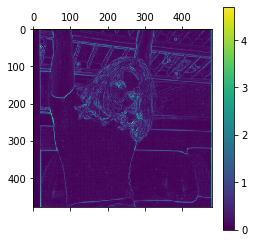

In [209]:
display_mat(mean_differences_array)
gradient_magnitude = mean_differences_array

In [210]:
avgpool = torch.nn.AdaptiveAvgPool2d((60,60))
maxpool = torch.nn.AdaptiveMaxPool2d((60,60))
patch_gradient_magnitude = avgpool(torch.from_numpy(gradient_magnitude).unsqueeze(dim=0))
patch_entropy = avgpool(entropy)

In [211]:
patch_gradient_magnitude = patch_gradient_magnitude.reshape(-1)
patch_entropy = patch_entropy.reshape(-1)

In [212]:
patch_gradient_magnitude_p = patch_gradient_magnitude / patch_gradient_magnitude.sum()
patch_entropy_p = patch_entropy / patch_entropy.sum()

In [213]:
#647,  710,  711,  770,  833
chose_index = 710
patch_gradient_magnitude_p[chose_index], patch_entropy_p[chose_index]

(tensor(0.0005, dtype=torch.float64), tensor(6.4672e-06))

In [214]:
small_k_entopy = torch.argsort(patch_entropy_p)[:900]
l = [647,  710,  711,  770,  833]
for i in l:
    if i in small_k_entopy:
        print(f"{i} Exists")

647 Exists
711 Exists
833 Exists


In [192]:
new_patch_gradient_magnitude_p = patch_gradient_magnitude_p[small_k_entopy]
top_k = torch.argsort(new_patch_gradient_magnitude_p)[-200:]
l = [647,  710,  711,  770,  833]
for i in l:
    if i in top_k:
        print(f"{i} Exists")

In [227]:
small_k_entopy = torch.argsort(patch_gradient_magnitude_p)[-900:]
l = [647,  710,  711,  770,  833]
for i in l:
    if i in small_k_entopy:
        print(f"{i} Exists")

647 Exists
710 Exists
711 Exists
770 Exists
833 Exists


In [207]:
new_patch_entropy_p = patch_entropy_p[small_k_entopy]
top_k = torch.argsort(new_patch_entropy_p)[:900]
l = [647,  710,  711,  770,  833]
for i in l:
    if i in top_k:
        print(f"{i} Exists")

647 Exists
710 Exists
711 Exists
770 Exists
833 Exists


In [72]:
diff.argmax()

tensor(1683)

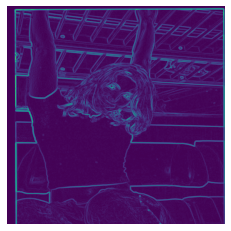

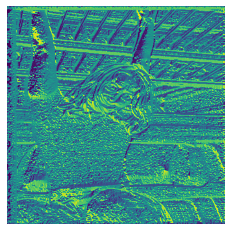

In [48]:
plt.imshow(gradient_magnitude)
plt.axis('off')  # Turn off axes
plt.show()
plt.imshow(gradient_direction)
plt.axis('off')  # Turn off axes
plt.show()